In [1]:
#Imports
import json
import numpy as np
import pandas as pd
import csv
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from peakutils import indexes

In [2]:
def jasonReader(path):
    """ Reads the .jason generated with jasonGenartor the given path"""
    with open(path,'r') as miarch:
        loaded_dict = json.loads(miarch.read())
    return loaded_dict

In [3]:
def wholecellParser(dictres):
    #extract all the slices data
    allSlices = dictres['image']
    #seting columns names
    column_names = ['max_peaks_positions','max_peaks_intensities','min_peaks_positions','min_peaks_intensities','amplitudes','times_to_peaks','tau_s']
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in column_names:
        df_sum.loc[:,i] = allSlices[i][:2]

    return df_sum

In [59]:
def derivate_date(array):
    return np.gradient(array, axis=None, edge_order=1)

In [24]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
  12         the length of the window. Must be an odd integer number.
  13     order : int
  14         the order of the polynomial used in the filtering.
  15         Must be less then `window_size` - 1.
  16     deriv: int
  17         the order of the derivative to compute (default = 0 means only smoothing)
  18     Returns
  19     -------
  20     ys : ndarray, shape (N)
  21         the smoothed signal (or it's n-th derivative).
  22     Notes
  23     -----
  24     The Savitzky-Golay is a type of low-pass filter, particularly
  25     suited for smoothing noisy data. The main idea behind this
  26     approach is to make for each point a least-square fit with a
  27     polynomial of high order over a odd-sized window centered at
  28     the point.
  40     References
  41     ----------
  42     .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
  43        Data by Simplified Least Squares Procedures. Analytical
  44        Chemistry, 1964, 36 (8), pp 1627-1639.
  45     .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
  46        W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
  47        Cambridge University Press ISBN-13: 9780521880688
  48     """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [5]:
def slicesParser_gradient(dictres,min_dist_between_max_peak):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(dictres['image']['max_peaks_positions']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    for _slice in range(len(allSlices)):
        slice_intensities = allSlices[_slice]['intensities']
        #calculate gradient
        yhat = derivate_date(np.array(slice_intensities))
#         yhat = savitzky_golay(np.array(slice_intensities), 25, int(len(allSlices[_slice]['intensities'])/min_dist_between_max_peak),1)
        #Maximun gradient
        amp_list = _max_peaks_positions(yhat, min_dist_between_max_peak)
        gradient_list = _intensities_in_positions(yhat, amp_list)[:len(dictres['image']['max_peaks_positions'])]
        if len(gradient_list)==len(dictres['image']['max_peaks_positions']):
            #populating the dataframe
            df_sum.loc[_slice] = gradient_list
        else:
            pass
    return df_sum

In [49]:
def _max_peaks_positions(vector, min_dist_between_max_peaks):
    threshold = 0.2
    possible_max_peaks = indexes(np.array(vector), thres=threshold, min_dist=min_dist_between_max_peaks)
    intensity_avg = sum(vector) / len(vector)
    max_peaks = [max_peak for max_peak in possible_max_peaks if vector[max_peak] > intensity_avg/8]

    if len(max_peaks) == 0: raise ValueError("Peaks not found")

    return max_peaks

def _analyze_matrix_slice(matrix, max_peaks_positions):
    intensities = np.asarray(_mean_columns(matrix), dtype=np.float16)
    max_peaks_intensities = _intensities_in_positions(intensities, max_peaks_positions)

    return ({
        "max_peaks_intensities": max_peaks_intensities,

    })
def _intensities_in_positions(intensities, positions):
    return [intensities[position] for position in positions]

def _mean_columns(slice):
    return np.asarray([float(np.mean(row)) for row in slice])

In [40]:
def discordance_index(path,min_dist_between_max_peaks):
    DIs = pd.DataFrame()
    for j in range (1,len(slicesParser_gradient(path,min_dist_between_max_peaks).columns)):
        rel_diff = []
        for i in range (1, len (slicesParser_gradient(path,min_dist_between_max_peaks))):
            T1 = list(slicesParser_gradient(path,min_dist_between_max_peaks)['transient'+str(j)])[i]
            T2 = list(slicesParser_gradient(path,min_dist_between_max_peaks)['transient'+str(j+1)])[i]
            rel_diff.append((T1-T2)/max(T1,T2))
        DIs[j] = rel_diff
    return DIs

In [9]:
path_imagenes = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/'
df_tabulado = pd.read_csv(path_imagenes + 'tabulado_imagenes.csv', index_col= 'Unnamed: 0')

dict_min_dist = {1:200,3:70,4:50,5:40} 

In [10]:
df_tabulado[(df_tabulado['experimento']==160712) &  (df_tabulado['foto'].isin(['5b000']))]['frecuencia'].reset_index(drop=True)

0    5
Name: frecuencia, dtype: int64

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/imagenes/37°/'
df = pd.DataFrame()
for foto in os.listdir(path):
    if 'json' in foto:
        print(foto)
        experiment = foto.split('_')[1][:6]
        photo = foto.split('_')[-1].split('.')[0]
        frec = df_tabulado[(df_tabulado['experimento'].isin([experiment])) &  (df_tabulado['foto'].isin([photo]))]['frecuencia'].reset_index(drop=True)[0]
        min_dist_between_max_peaks = dict_min_dist[frec]
        array = jasonReader(path + foto)
        discordance_list = discordance_index(array,min_dist_between_max_peaks).std()
        df[foto[:-4]] = discordance_list

37_040412_c3b000.json
37_030412_c1e000.json
37_200712_3c001.json
37_160712_5b000.json
37_030412_c4b000.json


KeyError: 0

In [56]:
dictres = jasonReader('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/imagenes/37°/37_040412_c4b003.json')
array = dictres['image']['intensities']

{'max_peaks_intensities': [5.0, 5.0, 5.0, 5.5, 4.5, 5.0, 5.0, 5.5, 5.0, 5.0]}

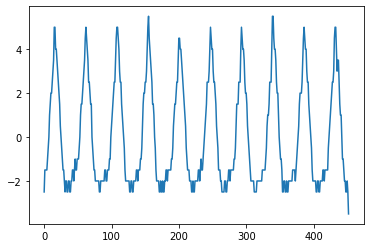

In [58]:
deriv = derivate_date(array)
plt.plot(deriv)

_analyze_matrix_slice(deriv, _max_peaks_positions(deriv, 40))

{'max_peaks_intensities': [5.0, 5.0, 5.0, 5.5, 4.5, 5.0, 5.0, 5.5, 5.0, 5.0]}
{'max_peaks_intensities': [4.438, 4.44, 4.746, 4.723, 4.246, 4.332, 4.363, 4.848, 4.52, 4.473]}


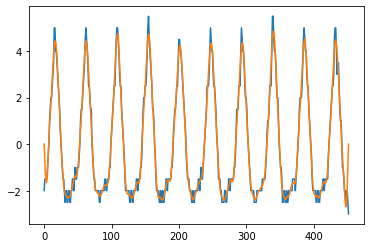

In [67]:
yhat = derivate_date(array)
yhat1 = savitzky_golay(np.array(array), 25, 8 ,1)
plt.plot(yhat)
plt.plot(yhat1)
print(_analyze_matrix_slice(yhat, _max_peaks_positions(yhat, 40)))
print(_analyze_matrix_slice(yhat1, _max_peaks_positions(yhat1, 40)))

In [55]:
df.T

,1,2,3,4,5,6,7,8,9
37_040412_c3b000.,0.195916,0.219756,0.243527,0.238577,0.214768,0.239588,0.244775,0.218333,0.193668
37_030412_c1e000.,0.228060,0.283185,0.272310,0.267293,0.204729,0.228750,0.276483,0.208576,0.228327
37_200712_3c001.,0.388329,0.332736,0.258113,0.383209,0.444066,0.361300,0.342880,0.407607,NaN
37_160712_5b000.,0.330156,0.340152,0.345229,0.286137,0.255986,0.249581,0.261645,0.311218,NaN


In [85]:
df.T.to_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/DI_gradient_37.csv',decimal = ',')

### Precisión y exactitud amplitud

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/jsons/'
file_tabulado = pd.read_excel(path + 'tab_prueba2.xlsx')
del file_tabulado['Unnamed: 0']

In [ ]:
df_manual = pd.read_csv("/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/DI_manual_1hz.csv", sep=",")
df_manual.head(2)

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
dif_amp = pd.DataFrame()
dias = df_manual['experimento'].drop_duplicates()
foto = df_manual['foto'].drop_duplicates()
for j in dias:
    for k in foto:
        for i in range(0,len (experiments)):
            if (str(j) in experiments[i]) & (k in experiments[i]):
                try:
                    experiment = jasonReader(path + 'jsons/' + experiments[i])
                    df_file = wholecellParser(experiment)
                    df_file['file'] = experiments[i]
                    dif_amp = dif_amp.append(df_file, ignore_index=True)
                except:
                    print(experiments[i])

In [ ]:
dif_amp.to_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/amp_cadiap_5hz.csv')

In [ ]:
amp_cardiap = pd.read_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/amp_cadiap.csv')
amp_cardiap.head(2)

In [ ]:
import scipy.stats

x = amp_cardiap['TTP_norm'].dropna()
y = df_manual ['TTP_manual'].dropna()
scipy.stats.pearsonr(x, y)

In [ ]:
df = pd.DataFrame((x,y)).T
def outliers(df,column,percentiles):
    Q1 = df[column].quantile(percentiles[0])
    Q3 = df[column].quantile(percentiles[1])
    IQR = Q3 - Q1
    idx = ~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))
    df = df[idx.values]
    return df

df = outliers(df,'TTP_norm',[0.02,0.98])
df = outliers(df,'TTP_manual',[0.02,0.98])

In [ ]:
import matplotlib.pyplot as pp

# plot
pp.scatter(df['TTP_norm'],df['TTP_manual'])
pp.xlabel('times_to_peaks-CardIAP')
pp.ylabel('TTP-manual')

# pp.savefig('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/TTP_cadiap_1hz.png')

In [ ]:
from scipy import stats
from sklearn.metrics import r2_score
#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

line = slope*x+intercept
lines = plt.plot(x, line, 'cornflowerblue', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
#end
plt.setp(lines, color='cornflowerblue', linewidth=2.0,linestyle = ':')
plt.scatter(x,y, color="k", s=3.5)
plt.legend(fontsize=9)
plt.annotate("r-squared = {:.3f}".format(r2_score(x, y)), (0, 1))
# pp.savefig('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/TTP_cadiap_1hz.png')

In [ ]:
from statistics import variance

diff = x[:48]-y[:48]
print(diff.mean())
print(diff.std())
print(x[:48].mean(),x[:48].std(),variance(x[:48]),y[:48].mean(),y[:48].std(),variance(y[:48]))

In [ ]:
stats.ttest_1samp(diff, 0.0)

In [ ]:
scipy.stats.levene(x[:48],y[:48],center='trimmed', proportiontocut=0.05)

## Análisis de AR

In [ ]:
path_ar = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/ARs/'

In [ ]:
path_tabulado = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/'
file_tabulado = pd.read_csv(path_tabulado + 'tabulado_imagenes.csv')
del file_tabulado['Unnamed: 0']

In [ ]:
experiments = os.listdir(path_ar)
dif_amp = []
dias = file_tabulado['experimento'].drop_duplicates()
foto = file_tabulado['foto'].drop_duplicates()
for j in dias:
    for k in foto:
        for i in range(0,len (experiments)):
            if (str(j) in experiments[i]) & (k in experiments[i]):
                file_tabulado['experimento']
                ar = pd.read_csv(path_ar + experiments[i],sep='\t',decimal=',')
                dif_amp.append([experiments[i],ar['local AR'].mean()])
                index = file_tabulado.index[(file_tabulado['experimento'] == j) & (file_tabulado['foto'] == k)].tolist()
                file_tabulado.loc[index,'AR'] = ar['local AR'].mean()

In [ ]:
file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['AR']<0.3) & (file_tabulado['frecuencia']==5)]

In [ ]:
file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==1)]['AR'].plot.hist(bins=20, alpha=0.5)
file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'].plot.hist(bins=20, alpha=0.5)

In [ ]:
print(file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==1)]['AR'].median())
print(file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==1)]['AR'].std())
print(file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'].median())
print(file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'].std())

In [ ]:
from scipy import stats

stats.ks_2samp(file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==5)]['AR'], file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'])

### DICRI

In [ ]:
tab = pd.read_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/tabulado_imagenes.csv', encoding='utf-8')
del tab['Unnamed: 0']
pd.set_option('display.max_rows', None)
controles = tab[tab['tratamiento'] == 'c']
controles = controles.reset_index(drop=True)

In [ ]:
exps = os.listdir(path + 'jsons/')
experiments = []
for j in range(0,len(exps)):
    for i in range(0,len(controles)):
        if str(controles['experimento'][i]) in exps[j]:
            if str(controles['foto'][i]) in exps[j]:
                experiments.append(exps[j])

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
# experiments = os.listdir(path + 'jsons/')
complete_file = pd.DataFrame()
for i in range(0,len (experiments)):
    try:
        experiment = jasonReader(path + 'jsons/' + experiments[i])
        amp_files = slicesParser_amplitudes(experiment).filter(['transient1','transient2'])
        amp_files = amp_files[:][0:33]
        transient_max = []
        for j in range(1,len(amp_files)+1):
            transient_max.append(max(amp_files['transient1'][j],amp_files['transient2'][j]))
        amp_files['transient_max'] = transient_max
        amp_files.loc[len(amp_files)+1] = (amp_files.mean())
        amp_files.loc[len(amp_files)+1] = [amp_files['transient1'][len(amp_files)]*100/amp_files['transient_max'][len(amp_files)],amp_files['transient2'][len(amp_files)]*100/amp_files['transient_max'][len(amp_files)],'']
        amp_files[str(experiments[i])] = list(range(1,len(amp_files)-1))+['promedios']+['porcentaje_max']
        complete_file = pd.concat([complete_file,amp_files], axis=1)
    except ValueError:
        print(experiments[i])

In [ ]:
complete_file.to_excel(path + 'DICRI_controles.xlsx', engine='xlsxwriter')  

### Amplitud de transitorio global vs DI

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/'
file_tabulado = pd.read_csv(path + 'tabulado_parceado.csv')
file_tabulado.head() 

In [ ]:
experiment = jasonReader(path + 'jsons/050320c8_analysis_result_8b000.json')
allSlices = experiment['slices']
for i in range(0,len(allSlices)):
    print(allSlices[i]['amplitudes'])

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/whole_cell/'
experiments = os.listdir(path)
df = pd.DataFrame()
for experiment in experiments:
    df = pd.read_csv(path + experiment, sep = '\t', index_col=0).loc['amplitudes']
    for imagen in range(0,len(file_tabulado)):
        cel = file_tabulado['célula'].loc[imagen]
        foto = file_tabulado['foto'].loc[imagen]
        if (cel in experiment) & (foto in experiment):
            print(experiment,df)

#     print (experiment, df)